<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/01_AR_forecasting_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AR(p) Forecasting — 4 Methods in R

여기서는 **4가지 학습/예측 전략**을 같은 데이터에 적용합니다.

1. **전체(Full series)**: 전체 구간으로 한 번 학습 → 미래 *h* 스텝 예측 (평가엔 부적합; 데이터 누수 위험)
2. **고정 원점(=정적 파라미터)**: 첫 80%만 학습 → 나머지 구간을 **재학습 없이** 예측
3. **롤링 윈도우(Rolling window)**: 최근 *W*개만으로 매 시점 재학습 → 1스텝 앞 예측
4. **확장 윈도우(Expanding window)**: 시작부터 *t−1*까지 전부로 매 시점 재학습 → 1스텝 앞 예측

> 모델은 **AR(p)** (ARIMA(p,0,0))를 사용합니다. 필요 시 p, W, 예측기간 h를 조정하세요.

In [1]:
# --- 기본 설정 & 패키지 설치/로드 ---
options(repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 150)
options(repos='https://cloud.r-project.org')
pkgs <- c('tidyverse','tidyquant','forecast','Metrics','glue')
to_install <- pkgs[!pkgs %in% installed.packages()[,'Package']]
if (length(to_install) > 0) install.packages(to_install)
suppressPackageStartupMessages({
  library(tidyverse)
  library(tidyquant)
  library(forecast)
  library(Metrics)
  library(glue)
})


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘globals’, ‘listenv’, ‘parallelly’, ‘mvtnorm’, ‘pcaPP’, ‘DEoptimR’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘sparsevctrs’, ‘furrr’, ‘crosstalk’, ‘warp’, ‘BH’, ‘RcppRoll’, ‘future’, ‘quadprog’, ‘pyinit’, ‘rrcov’, ‘robustbase’, ‘recipes’, ‘rsample’, ‘plotly’, ‘padr’, ‘slider’, ‘anytime’, ‘tsfeatures’, ‘lazyeval’, ‘PerformanceAnalytics’, ‘RobStatTM’, ‘quantmod’, ‘timetk’, ‘timeDate’, ‘TTR’, ‘xts’, ‘zoo’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘tseries’, ‘urca’, ‘RcppArmadillo’




## 데이터 로드 (TSLA, 2022-01-01 ~ 2025-09-30)

In [2]:
symbol <- 'TSLA'
start_date <- as.Date('2022-01-01')
end_date   <- as.Date('2025-09-30')

df <- tq_get(symbol, from = start_date, to = end_date, get = 'stock.prices') %>%
  select(date, close) %>% rename(Date = date, Close = close) %>% arrange(Date)
print(glue('Rows: {nrow(df)}  |  Range: {min(df$Date)} ~ {max(df$Date)}'))
head(df)


Rows: 938  |  Range: 2022-01-03 ~ 2025-09-29


Date,Close
<date>,<dbl>
2022-01-03,399.9267
2022-01-04,383.1967
2022-01-05,362.7067
2022-01-06,354.9000
2022-01-07,342.3200
2022-01-10,352.7067


## 파라미터 및 헬퍼 함수

In [3]:
p <- 10      # AR 차수
W <- 252     # 롤링 윈도우 길이(예: 1년 거래일)
h <- 20      # Full-series 미래 예측 스텝 수

y <- df$Close %>% as.numeric()
dates <- df$Date
n <- length(y)
split_idx <- floor(n * 0.8)  # 80/20 분할

r2 <- function(actual, pred) {
  1 - sum((actual - pred)^2) / sum((actual - mean(actual))^2)
}


## 1) 전체(Full series): 전체로 한 번 학습 → 미래 *h* 예측

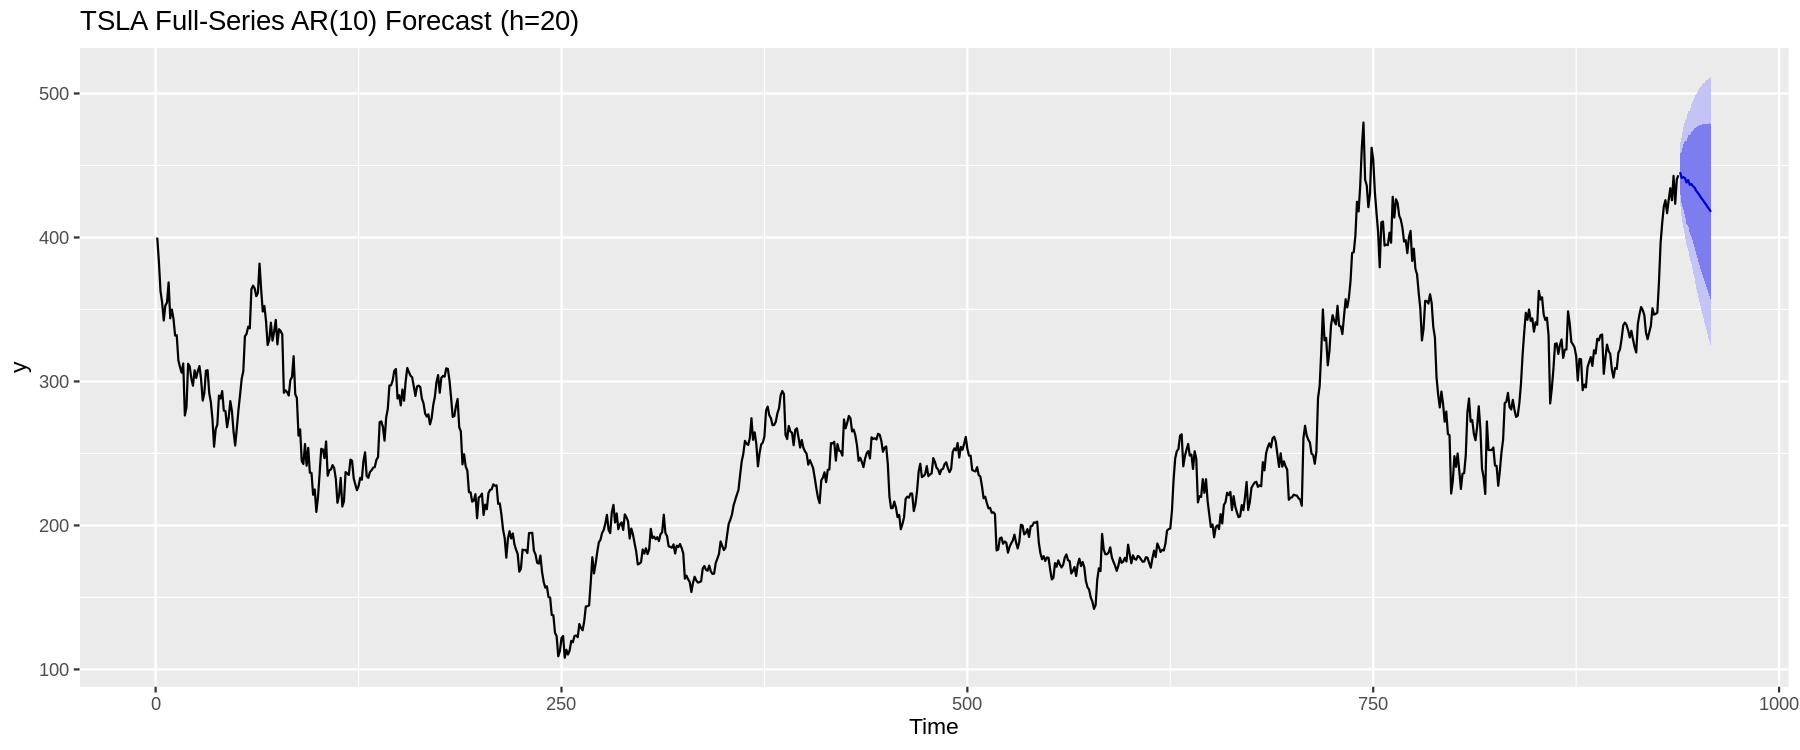

In [4]:
fit_full <- Arima(y, order = c(p, 0, 0), include.mean = TRUE)
fc_full  <- forecast(fit_full, h = h)
autoplot(fc_full) + ggtitle(glue('{symbol} Full-Series AR({p}) Forecast (h={h})'))


## 2) 고정 원점(=정적 파라미터) 예측: 첫 80%로 학습 → 나머지 재귀 예측

[Fixed-origin] RMSE=70.0743 | MAE=53.7170 | R2=-0.6619


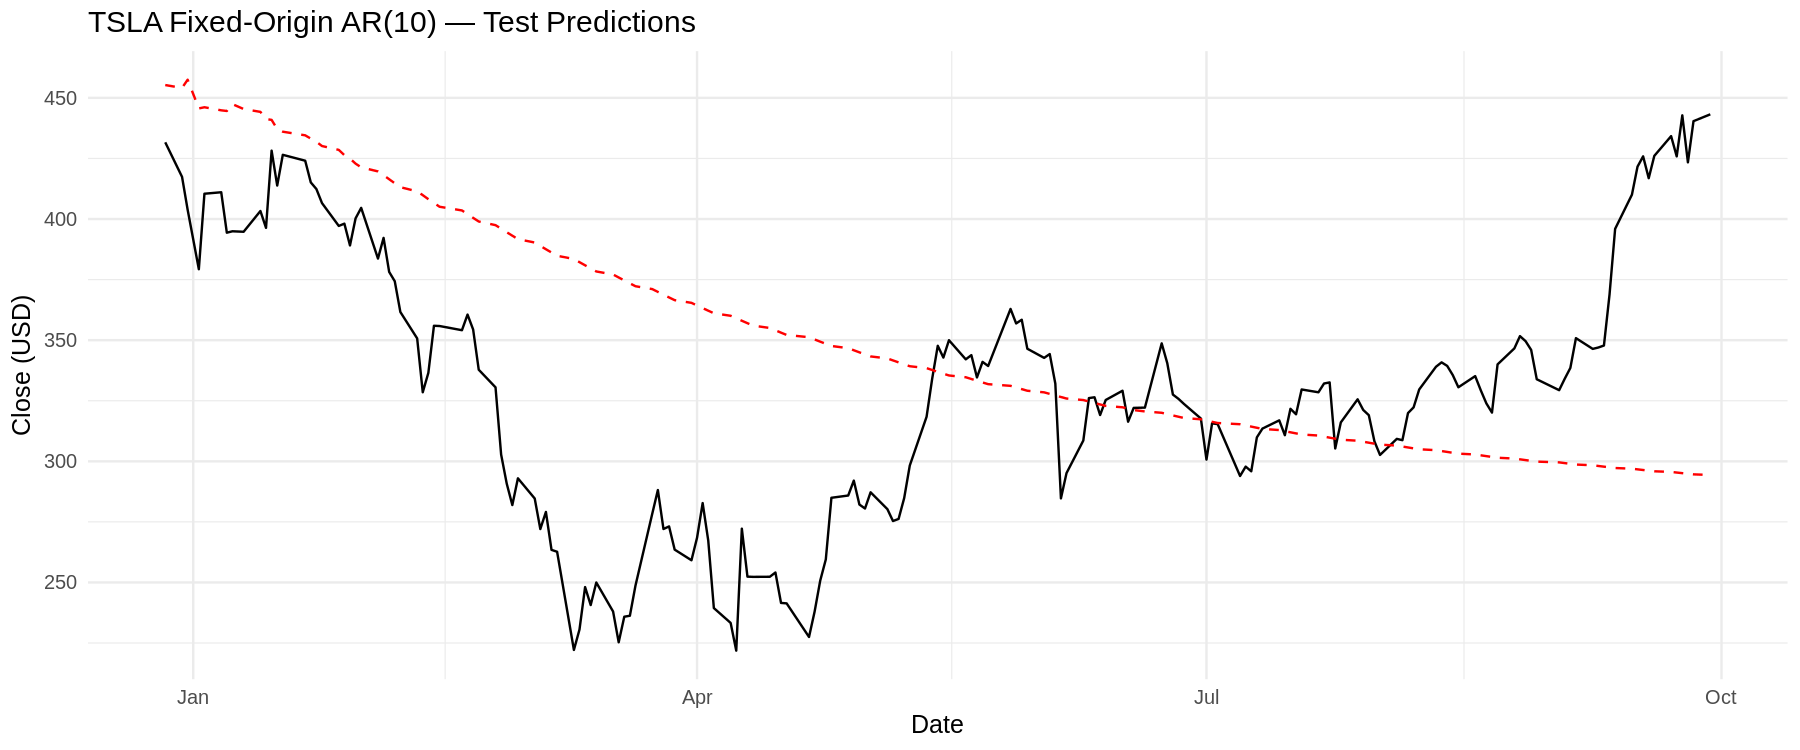

In [5]:
y_train <- y[1:split_idx]
y_test  <- y[(split_idx+1):n]
dates_test <- dates[(split_idx+1):n]

fit_fixed <- Arima(y_train, order = c(p, 0, 0), include.mean = TRUE)
pred_fixed <- as.numeric(forecast(fit_fixed, h = length(y_test))$mean)

rmse_fixed <- rmse(y_test, pred_fixed)
mae_fixed  <- mae(y_test, pred_fixed)
r2_fixed   <- r2(y_test, pred_fixed)
cat(sprintf('[Fixed-origin] RMSE=%.4f | MAE=%.4f | R2=%.4f\n', rmse_fixed, mae_fixed, r2_fixed))

ggplot(tibble(Date = dates_test, Actual = y_test, Pred = pred_fixed), aes(Date)) +
  geom_line(aes(y = Actual), color = 'black') +
  geom_line(aes(y = Pred), color = 'red', linetype = 'dashed') +
  labs(title = glue('{symbol} Fixed-Origin AR({p}) — Test Predictions'),
       x = 'Date', y = 'Close (USD)') + theme_minimal(base_size = 12)


## 3) 롤링 윈도우(Rolling window): 최근 *W*개로 매 시점 재학습 → 1스텝 예측

[Rolling] RMSE=13.3403 | MAE=10.3964 | R2=0.9398


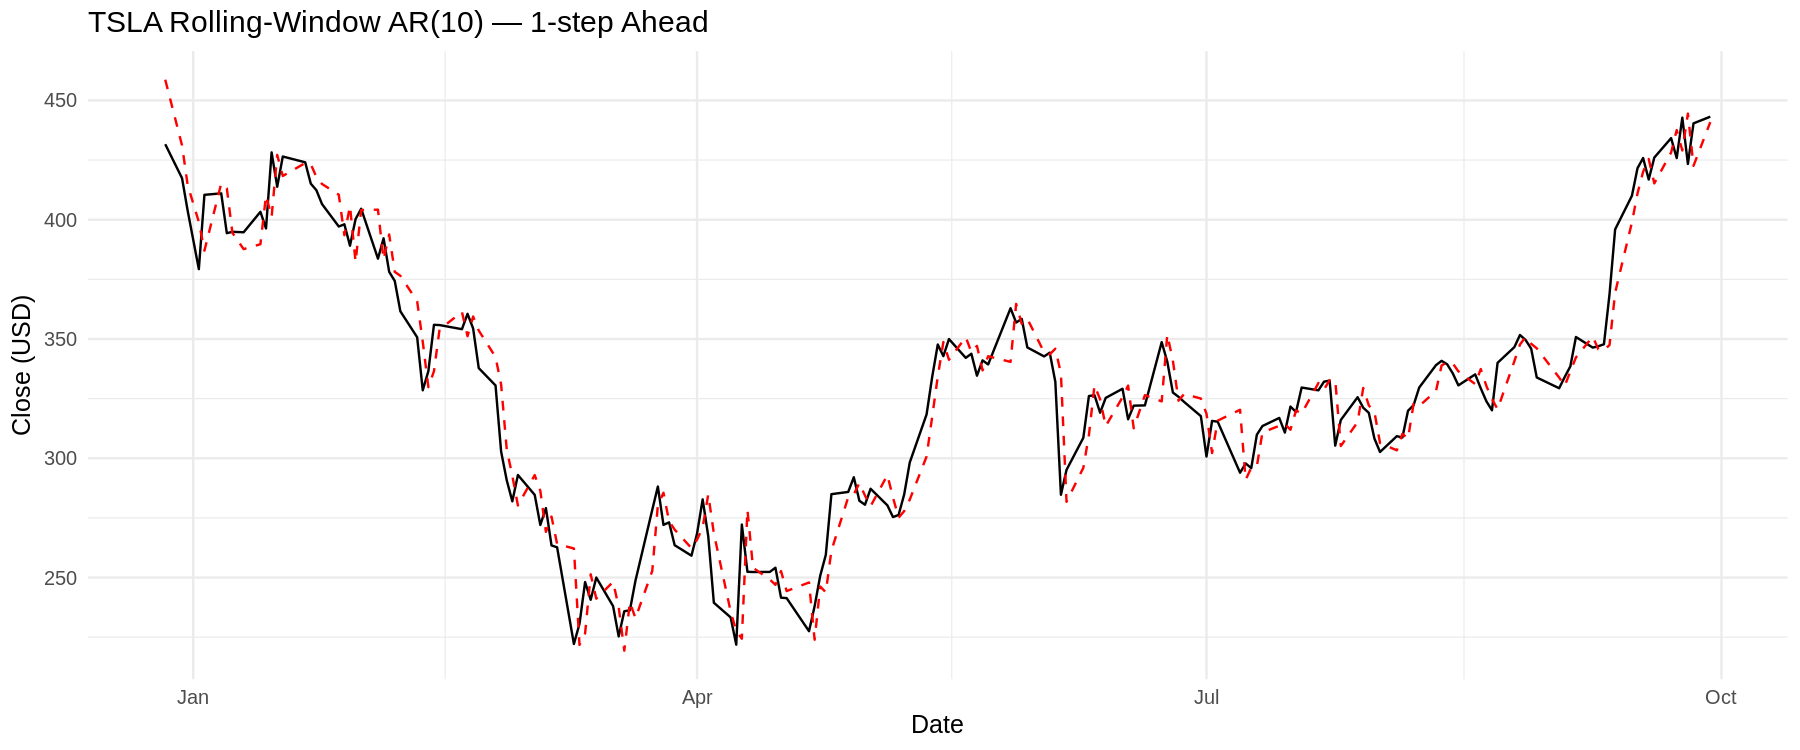

In [11]:
# --- 헬퍼: 윈도우별 안전한 AR 적합 함수 ---
fit_ar_safe <- function(x, p, method = "ML", max_d = 1) {
  if (length(x) < p + 2) stop("Not enough data in the window.")
  d_hat <- min(forecast::ndiffs(x), max_d)   # d ∈ {0,1}
  p_eff <- max(1, min(p, length(x) - d_hat - 1))

  fit <- tryCatch(
    forecast::Arima(
      x,
      order = c(p_eff, d_hat, 0),
      include.mean  = (d_hat == 0),
      include.drift = (d_hat == 1),   # ← d=1일 때만 드리프트
      method = method
    ),
    error = function(e) {
      forecast::auto.arima(
        x, seasonal = FALSE, max.q = 0, max.d = max_d,
        stepwise = TRUE, approximation = TRUE,
        allowdrift = TRUE, allowmean = TRUE
      )
    }
  )
  fit
}
# --- 롤링 예측 ---
pred_roll <- rep(NA_real_, length(y_test))

for (i in seq_along(y_test)) {
  t <- split_idx + i                # 전체 시계열 인덱스
  start_idx <- max(1, t - W)        # 최근 W개
  y_win <- y[start_idx:(t - 1)]     # t-1까지 학습

  if (length(y_win) < p + 2) next   # 데이터 부족 시 건너뜀

  fit <- fit_ar_safe(y_win, p)      # 안전 적합
  pred_roll[i] <- as.numeric(forecast::forecast(fit, h = 1)$mean)
}

mask <- !is.na(pred_roll)
rmse_roll <- Metrics::rmse(y_test[mask], pred_roll[mask])
mae_roll  <- Metrics::mae(y_test[mask],  pred_roll[mask])
r2_roll   <- 1 - sum((y_test[mask] - pred_roll[mask])^2) / sum((y_test[mask] - mean(y_test[mask]))^2)
cat(sprintf("[Rolling] RMSE=%.4f | MAE=%.4f | R2=%.4f\n", rmse_roll, mae_roll, r2_roll))

ggplot(tibble(Date = dates_test[mask], Actual = y_test[mask], Pred = pred_roll[mask]), aes(Date)) +
  geom_line(aes(y = Actual), color = "black") +
  geom_line(aes(y = Pred),   color = "red", linetype = "dashed") +
  labs(title = glue("{symbol} Rolling-Window AR({p}) — 1-step Ahead"),
       x = "Date", y = "Close (USD)") +
  theme_minimal(base_size = 12)


## 4) 확장 윈도우(Expanding window): 처음부터 *t−1*까지로 매 시점 재학습 → 1스텝 예측

[Expanding] RMSE=13.2563 | MAE=10.1962 | R2=0.9405


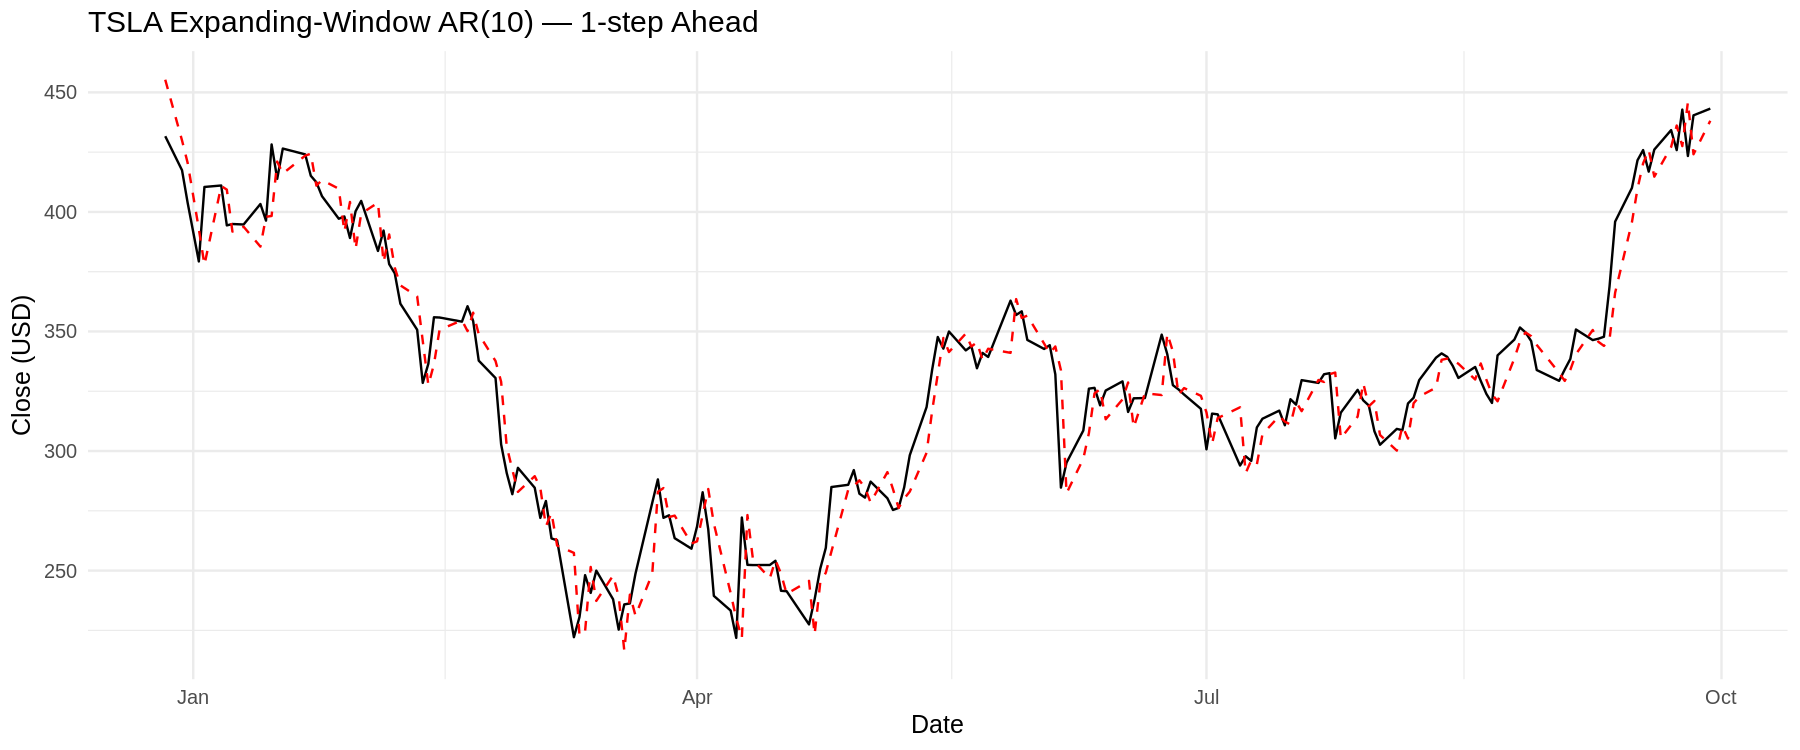

In [8]:
pred_exp <- rep(NA_real_, length(y_test))

for (i in seq_along(y_test)) {
  t <- split_idx + i
  y_win <- y[1:(t-1)]
  if (length(y_win) <= p) next
  fit <- Arima(y_win, order = c(p, 0, 0), include.mean = TRUE)
  pred_exp[i] <- as.numeric(forecast(fit, h = 1)$mean)
}

mask2 <- !is.na(pred_exp)
rmse_exp <- rmse(y_test[mask2], pred_exp[mask2])
mae_exp  <- mae(y_test[mask2], pred_exp[mask2])
r2_exp   <- r2(y_test[mask2], pred_exp[mask2])
cat(sprintf('[Expanding] RMSE=%.4f | MAE=%.4f | R2=%.4f\n', rmse_exp, mae_exp, r2_exp))

ggplot(tibble(Date = dates_test[mask2], Actual = y_test[mask2], Pred = pred_exp[mask2]), aes(Date)) +
  geom_line(aes(y = Actual), color = 'black') +
  geom_line(aes(y = Pred), color = 'red', linetype = 'dashed') +
  labs(title = glue('{symbol} Expanding-Window AR({p}) — 1-step Ahead'),
       x = 'Date', y = 'Close (USD)') + theme_minimal(base_size = 12)


## 요약: 고정/롤링/확장 성능 비교 테이블

In [12]:
summary_tbl <- tibble(
  Method = c('Fixed-origin (static)', 'Rolling window', 'Expanding window'),
  RMSE   = c(rmse_fixed, rmse_roll, rmse_exp),
  MAE    = c(mae_fixed,  mae_roll,  mae_exp),
  R2     = c(r2_fixed,   r2_roll,   r2_exp)
)
summary_tbl %>% arrange(RMSE)


Method,RMSE,MAE,R2
<chr>,<dbl>,<dbl>,<dbl>
Expanding window,13.25628,10.19616,0.9405238
Rolling window,13.34032,10.39638,0.9397672
Fixed-origin (static),70.07429,53.71696,-0.6619496


### 참고
- 가격 **레벨** 대신 `diff(Close)`나 `ROC`(수익률)에 AR(p)을 적용하면 더 안정적인 경우가 많습니다.
- AR 대신 ARIMA/ARIMAX 등으로 바꿔도 같은 4가지 전략을 그대로 적용할 수 있습니다.
- 그래프 기본 크기는 노트북 상단 `options(repr.plot.width/height/res)`에서 조정합니다.